<a href="https://colab.research.google.com/github/Huntac/network_mgmt/blob/main/network_ddpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Management Problem

## Summary

Using the [or-gym network management environment](https://github.com/hubbs5/or-gym/blob/master/or_gym/envs/supply_chain/network_management.py) to learn and evaluate RL agents and stochastic modeling methods to manage ordering from node to node in a supply chain network.  

The Agent used in this colab is a [DDPG agent](https://arxiv.org/pdf/1509.02971.pdf)


In [1]:
%%capture
!pip install or-gym
!pip install tensorflow
!cp drive/MyDrive/ddpg_scripts/ddpg_utils.py ddpg_utils.py
!cp drive/MyDrive/ddpg_scripts/ddpg_networks.py ddpg_networks.py
!cp drive/MyDrive/ddpg_scripts/ddpg_agent.py ddpg_agent.py

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import or_gym
from or_gym import create_env
from ddpg_agent import Agent

import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
print(f'GPU device name: {device_name}')

GPU device name: /device:GPU:0


In [3]:
# Create default environment
env_name = 'NetworkManagement-v1'
env_config = {}
env = or_gym.make(env_name, env_config = env_config)

In [4]:
# Inspect sample action, state and reward to ensure agent has loaded correctly
sample_action = env.sample_action()
sample_state, sample_reward, sample_done, other = env.step(sample_action)

print(sample_action)
print(sample_state)
print(sample_reward)

[1780 2140  448    1 2396 2269 1546  976  537 2648  220]
[   0.   79.    0.    0. 1285.  260.  440.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]
-403.137


In [5]:
# initialize ddpg agent
agent = Agent(
    input_dims = env.observation_space.shape,
    env= env,
    n_actions = env.action_space.shape[0],
    buffer_size = 100000,
    alpha = 0.003,
    beta = 0.003
)

In [6]:
# Initialize Run parameters
n_episodes = 2000
best_score = env.reward_range[0]
score_list = []
action_list = np.zeros((n_episodes,) + env.R.shape)
demand_list = np.zeros((n_episodes,) + env.D.shape)
pipeline_list = np.zeros((n_episodes,) + env.Y.shape)
inv_list = np.zeros((n_episodes,) + env.X.shape)
reward_list = np.zeros((n_episodes, env.num_periods) + sample_reward.shape)

In [7]:
for i in range(1, n_episodes + 1):
  # reset episode information
  ep_score = 0
  observation = env.reset()
  done = False
  t = 0
  # run episode
  while not done:
    action = agent.choose_action(observation).flatten()
    next_observation, reward, done, info = env.step(action)
    ep_score += reward
    agent.memory.add(observation, action, reward, next_observation, done)
    agent.learn()
    observation = next_observation
    action_list[i-1][t] = action
    reward_list[i-1][t] = reward
    t += 1

  score_list.append(ep_score)
  avg_score = np.mean(score_list[-100:])
  if ep_score > best_score:
    best_score = ep_score
    # agent.save_models()
  
  demand_list[i-1] = env.D
  pipeline_list[i-1] = env.Y
  inv_list[i-1] = env.X

  if (i % 25 == 0):
    print(f'episode: {i} | score = {ep_score:.2f} | avg_score: {avg_score:.2f} | '\
          + f'best_score: {best_score:.2f}')
  

episode: 25 | score = -4641.22 | avg_score: -4443.44 | best_score: -2442.12
episode: 50 | score = -4116.11 | avg_score: -4180.48 | best_score: -2404.16
episode: 75 | score = -2647.08 | avg_score: -4060.91 | best_score: -2364.08
episode: 100 | score = -3877.84 | avg_score: -4033.34 | best_score: -2364.08
episode: 125 | score = -4769.65 | avg_score: -3890.26 | best_score: -2364.08
episode: 150 | score = -4342.64 | avg_score: -3850.47 | best_score: -2364.08
episode: 175 | score = -3991.71 | avg_score: -3873.75 | best_score: -2364.08
episode: 200 | score = -4135.63 | avg_score: -3837.49 | best_score: -2364.08
episode: 225 | score = -4454.96 | avg_score: -3823.28 | best_score: -2364.08
episode: 250 | score = -4574.33 | avg_score: -3852.15 | best_score: -2364.08
episode: 275 | score = -4768.03 | avg_score: -3864.63 | best_score: -2364.08
episode: 300 | score = -4399.35 | avg_score: -3878.99 | best_score: -2364.08
episode: 325 | score = -3773.75 | avg_score: -3835.62 | best_score: -2364.08
ep

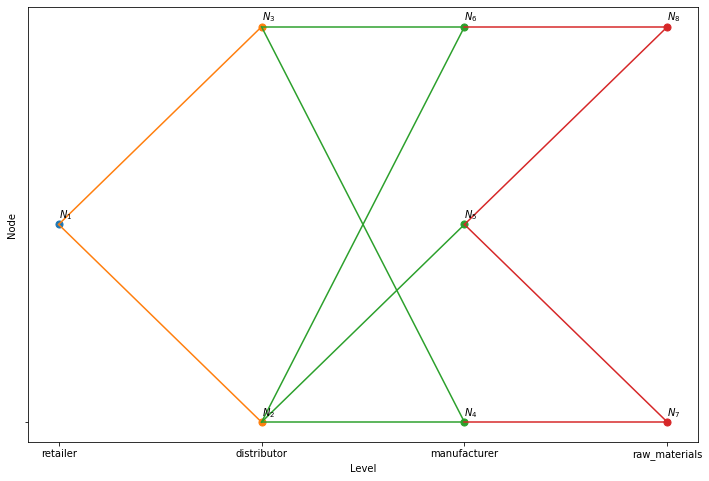

In [8]:
env.plot_network()

In [9]:
def plot_finals(
    sim_stat: np.ndarray, 
    stat_title: str,
    stat_legend: np.ndarray = None,
    subset: list = None):
  """
  Plot final stat at end of each episode
  """

  if subset is not None:
    sim_stat = sim_stat[:,:,(np.asarray(subset) - 1)]
    if stat_legend is not None:
      stat_legend = stat_legend[subset]
  plt.plot(sim_stat[:,30,:], '-')
  if stat_legend is not None:
    plt.legend(stat_legend.columns)
  plt.title(stat_title)
  plt.show

In [10]:
def plot_ep_totals(
    sim_stat: np.ndarray, 
    stat_title: str,
    stat_legend: np.ndarray = None,
    subset: list = None):
  """
  Plot final stat at end of each episode
  """

  sim_stat = np.sum(sim_stat, axis = 1)
  if subset is not None:
    sim_stat = sim_stat[:,(np.asarray(subset) - 1)]
  plt.plot(sim_stat, '-')
  if stat_legend is not None:
    plt.legend(stat_legend.columns)
  plt.title(stat_title)
  plt.show

In [11]:
rm_links = [ind for ind, link in enumerate(env.reorder_links) if link[0] in env.rawmat]
factory_links = [ind for ind, link in enumerate(env.reorder_links) if link[0] in env.factory]
distrib_links = [ind for ind, link in enumerate(env.reorder_links) if link[0] in env.distrib[1:]]
retail_links = [ind for ind, link in enumerate(env.reorder_links) if link[0] in env.retail]

## Agent Summary

The DDPG agent has clearly not learned the task effectively. The score plot and really all the plots at this point look like a random walk over time 

<function matplotlib.pyplot.show>

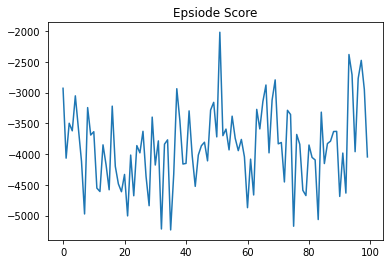

In [12]:
plt.plot(score_list[-100:])
plt.title('Epsiode Score')
plt.show

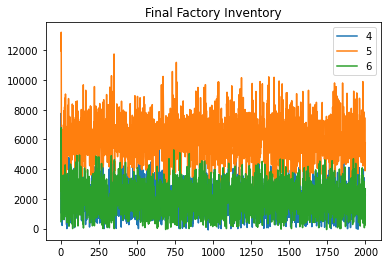

In [13]:
plot_finals(inv_list, 'Final Factory Inventory', env.X, env.factory)

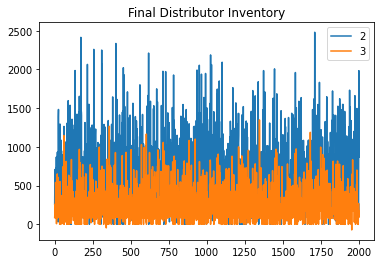

In [14]:
plot_finals(inv_list, 'Final Distributor Inventory', env.X, env.distrib[1:])

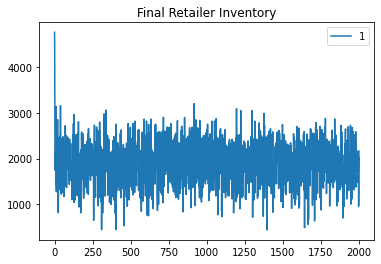

In [15]:
plot_finals(inv_list, 'Final Retailer Inventory', env.X, env.retail)

The Total epsiode demand is plotted below. Compared to the terminal inventory plots as well as the reorder plots (the agent's actual actions) we can clearly see that the agent has not learned to order in accordance with demand for any nodes

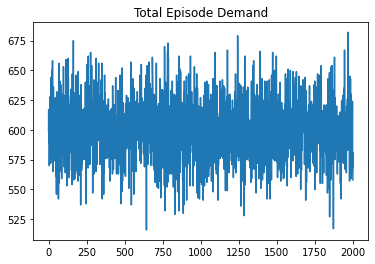

In [16]:
plt.plot(np.sum(demand_list, axis = 1))
plt.title('Total Episode Demand')
plt.show()

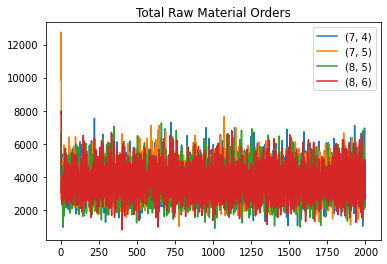

In [17]:
plot_ep_totals(action_list, 'Total Raw Material Orders', env.R[env.rawmat], rm_links)

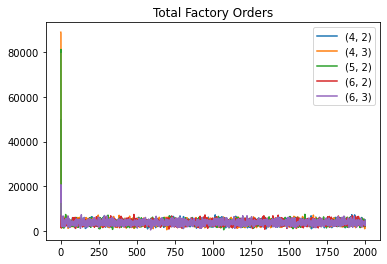

In [18]:
plot_ep_totals(action_list, 'Total Factory Orders', env.R[env.factory], factory_links)

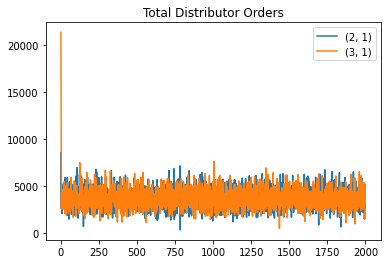

In [19]:
plot_ep_totals(action_list, 'Total Distributor Orders', env.R[env.distrib[1:]], distrib_links)

Demonstrated below node 1's reorders to nodes 2 and 3 is not correlated at all with market demand which means that the DDPG is essentially acting randomly

In [23]:
total_demand = np.concatenate(np.sum(demand_list, axis = 1))
node_2_orders = np.sum(action_list, axis=1)[:,0]
node_3_orders = np.sum(action_list, axis=1)[:,1]

In [24]:
np.corrcoef(total_demand, node_2_orders)

array([[1.        , 0.00464648],
       [0.00464648, 1.        ]])

In [25]:
np.corrcoef(total_demand, node_3_orders)

array([[1.        , 0.00619728],
       [0.00619728, 1.        ]])